In [3]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor


In [4]:
df=pd.read_csv('MergedData.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')


In [5]:
model1_features = [
    "temperature_2m", "relative_humidity_2m", "wind_speed_10m", "surface_pressure",
    "precipitation",
    "pm2_5_lag1", "pm2_5_lag7",
    "pm2_5_ma7", "pm2_5_ma14",
    "sin_doy", "cos_doy"
]
target="pm2_5"
print(df[model1_features + [target]].describe().T[['mean','std','min','max']])

                            mean        std         min         max
temperature_2m         23.333039   2.227190   17.391111   31.656734
relative_humidity_2m   70.810611  14.303341   28.891815   95.899330
wind_speed_10m         12.259712   4.448857    3.498313   28.586784
surface_pressure      913.036937   2.290530  906.857540  918.834660
precipitation          15.743884  29.755796    0.000000  246.800000
pm2_5_lag1             20.472397  12.194829    0.700000   63.300000
pm2_5_lag7             20.390165  12.177042    0.700000   63.300000
pm2_5_ma7              20.432220  10.438020    2.657143   52.985714
pm2_5_ma14             20.385714   9.558854    3.271429   40.507143
sin_doy                -0.078168   0.717147   -0.999991    0.999991
cos_doy                 0.016859   0.692913   -0.999963    1.000000
pm2_5                  20.490083  12.212407    0.700000   63.300000


In [6]:
X = df[model1_features].values
y = df[target].values

# Hold out last 10% for final validation
holdout_n = max(1, int(0.1 * len(df)))
X_trainval, X_hold = X[:-holdout_n], X[-holdout_n:]
y_trainval, y_hold = y[:-holdout_n], y[-holdout_n:]
print("Train+CV rows:", len(X_trainval), "Holdout rows:", len(X_hold))


Train+CV rows: 1089 Holdout rows: 121


In [7]:
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
tscv = TimeSeriesSplit(n_splits=5)
train_idx, val_idx= list(tscv.split(X_trainval))[-1]
X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
y_train, y_val = y_trainval[train_idx], y_trainval[val_idx] 

model = XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=3, 
                     subsample=0.6, colsample_bytree=0.6, objective='reg:squarederror',
                     random_state=42, verbosity=0, early_stopping_rounds=50)

model.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
          
          verbose=False)
pred=model.predict(X_val)
print("MAE", mean_absolute_error(y_val, pred))
print("RMSE", root_mean_squared_error(y_val, pred))

MAE 3.026383754825065
RMSE 4.408043647156204


In [8]:
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
maes,rmses=[],[]

for i, (train_idx, val_idx) in enumerate(tscv.split(X_trainval)):
    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx] 

    m = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, 
                     subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror',
                     random_state=42, verbosity=0,
                      early_stopping_rounds=50)

    m.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
         
          verbose=False)
    pred=m.predict(X_val)
    mae=mean_absolute_error(y_val, pred)
    rmse=root_mean_squared_error(y_val, pred)
    maes.append(mae)
    rmses.append(rmse)
    print(f"Fold {i+1} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Fold 1 - MAE: 3.6778, RMSE: 4.6268
Fold 2 - MAE: 4.7241, RMSE: 5.9834
Fold 3 - MAE: 2.9486, RMSE: 3.7997
Fold 4 - MAE: 5.8089, RMSE: 8.3381
Fold 5 - MAE: 2.9946, RMSE: 4.4738


In [9]:
final=XGBRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, 
                     subsample=0.6, colsample_bytree=0.6, objective='reg:squarederror',
                     random_state=42, verbosity=0, early_stopping_rounds=50)
final.fit(X_trainval, y_trainval, 
          eval_set=[(X_hold, y_hold)],verbose=True)
pred_hold=final.predict(X_hold)
print("Final Holdout MAE:", mean_absolute_error(y_hold, pred_hold))
print("Final Holdout RMSE:", root_mean_squared_error(y_hold, pred_hold))

[0]	validation_0-rmse:12.98580
[1]	validation_0-rmse:12.89237
[2]	validation_0-rmse:12.82289
[3]	validation_0-rmse:12.75880
[4]	validation_0-rmse:12.67059
[5]	validation_0-rmse:12.58104
[6]	validation_0-rmse:12.49020
[7]	validation_0-rmse:12.40558
[8]	validation_0-rmse:12.31586
[9]	validation_0-rmse:12.25191
[10]	validation_0-rmse:12.17155
[11]	validation_0-rmse:12.09115
[12]	validation_0-rmse:12.00810
[13]	validation_0-rmse:11.92588
[14]	validation_0-rmse:11.86429
[15]	validation_0-rmse:11.80145
[16]	validation_0-rmse:11.72126
[17]	validation_0-rmse:11.66927
[18]	validation_0-rmse:11.61540
[19]	validation_0-rmse:11.56125
[20]	validation_0-rmse:11.48124
[21]	validation_0-rmse:11.41496
[22]	validation_0-rmse:11.34184
[23]	validation_0-rmse:11.29133
[24]	validation_0-rmse:11.22368
[25]	validation_0-rmse:11.16082
[26]	validation_0-rmse:11.10281
[27]	validation_0-rmse:11.03686
[28]	validation_0-rmse:10.96613
[29]	validation_0-rmse:10.89594
[30]	validation_0-rmse:10.83038
[31]	validation_0-

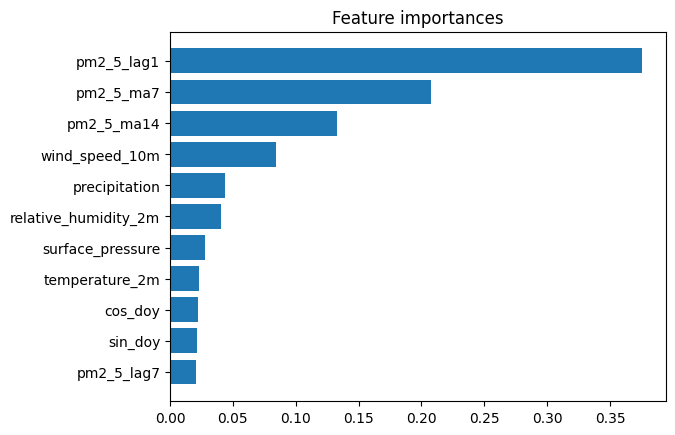

In [10]:
import numpy as np
import matplotlib.pyplot as plt

importances = final.feature_importances_
idx = np.argsort(importances)[::-1]
plt.barh(np.array(model1_features)[idx], importances[idx])
plt.gca().invert_yaxis()
plt.title("Feature importances")
plt.show()


In [11]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    "n_estimators": [200, 500, 800],
    "max_depth": [3, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}
rs = RandomizedSearchCV(
    estimator=XGBRegressor(objective="reg:squarederror", random_state=42, verbosity=0),
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=3),
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs.fit(X_trainval, y_trainval)   # NOTE: no early stopping here (search simplicity)
print("Best params:", rs.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'subsample': 0.6, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


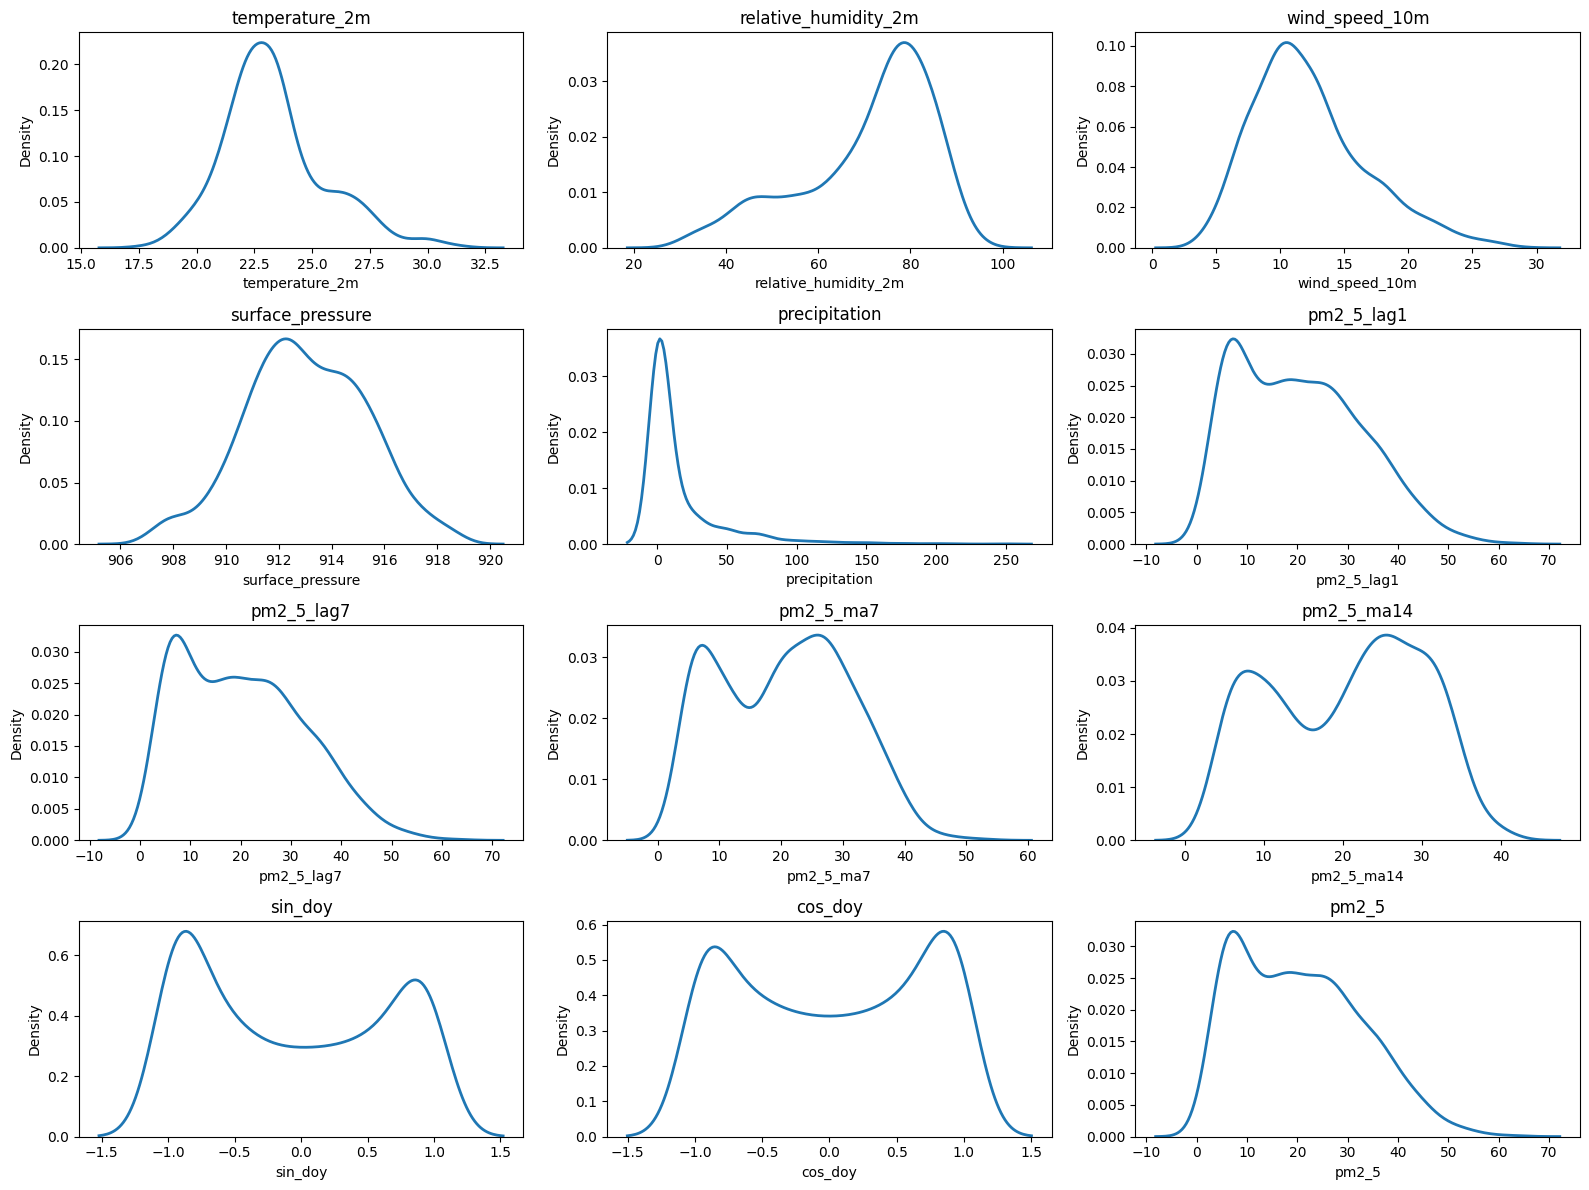

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = model1_features + ['pm2_5']   # include target if you want

plt.figure(figsize=(16, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(4,3, i)  # Adjust rows/cols depending on number of features
    sns.kdeplot(df[col], linewidth=2)
    plt.title(col)
    plt.tight_layout()

plt.show()


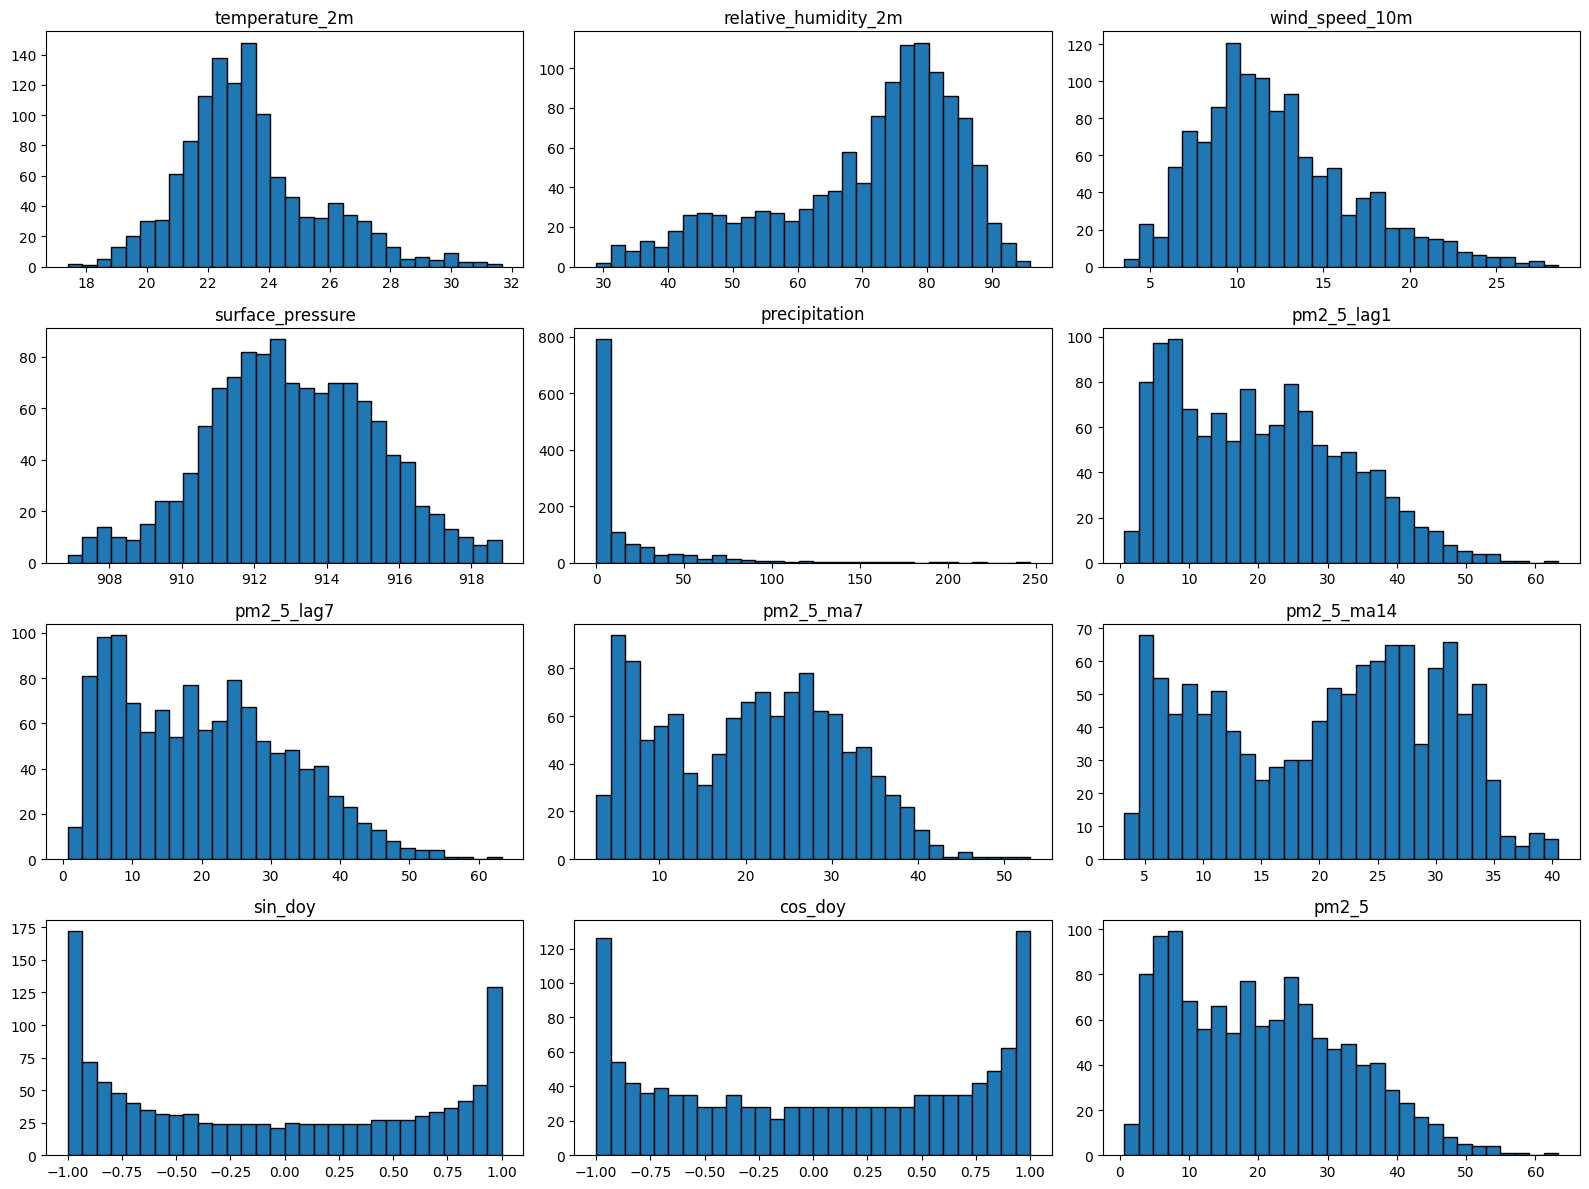

In [13]:
import matplotlib.pyplot as plt

cols = model1_features + ['pm2_5']   # all features + target

plt.figure(figsize=(16, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 3, i)  # Adjust grid size depending on number of features
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.show()


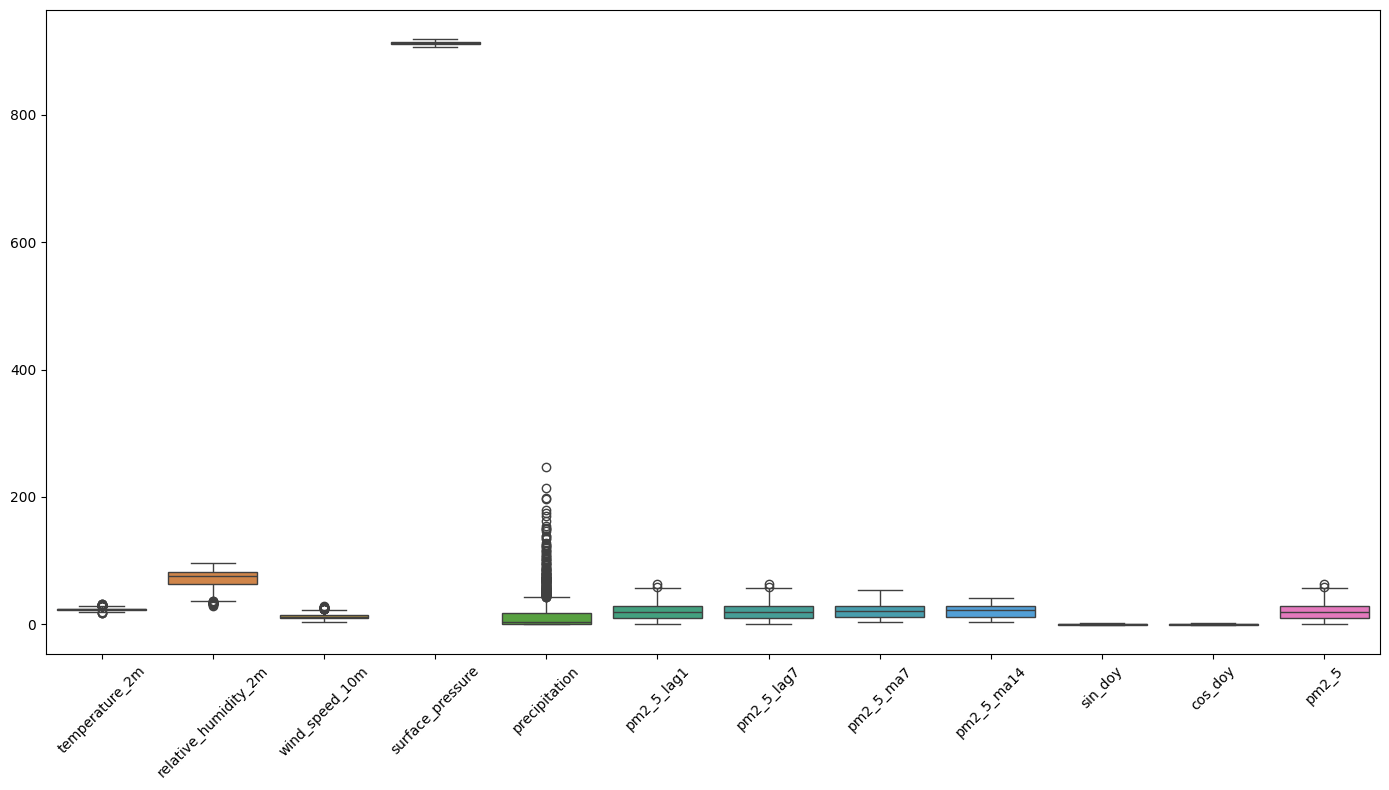

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,8))
sns.boxplot(data=df[model1_features + ['pm2_5']])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1210 non-null   datetime64[ns]
 1   temperature_2m         1210 non-null   float64       
 2   relative_humidity_2m   1210 non-null   float64       
 3   wind_speed_10m         1210 non-null   float64       
 4   surface_pressure       1210 non-null   float64       
 5   precipitation          1210 non-null   float64       
 6   pm10                   1210 non-null   float64       
 7   pm2_5                  1210 non-null   float64       
 8   carbon_monoxide        1210 non-null   float64       
 9   nitrogen_dioxide       1210 non-null   float64       
 10  sulphur_dioxide        1210 non-null   float64       
 11  ozone                  1210 non-null   float64       
 12  dayofyear              1210 non-null   int64         
 13  sin

In [16]:
cols=df.columns.difference(['date'])
print(df[df[cols] < 0])

     date  temperature_2m  relative_humidity_2m  wind_speed_10m  \
0     NaT             NaN                   NaN             NaN   
1     NaT             NaN                   NaN             NaN   
2     NaT             NaN                   NaN             NaN   
3     NaT             NaN                   NaN             NaN   
4     NaT             NaN                   NaN             NaN   
...   ...             ...                   ...             ...   
1205  NaT             NaN                   NaN             NaN   
1206  NaT             NaN                   NaN             NaN   
1207  NaT             NaN                   NaN             NaN   
1208  NaT             NaN                   NaN             NaN   
1209  NaT             NaN                   NaN             NaN   

      surface_pressure  precipitation  pm10  pm2_5  carbon_monoxide  \
0                  NaN            NaN   NaN    NaN              NaN   
1                  NaN            NaN   NaN    NaN   

In [17]:
final.save_model("model2_xgb.json")


In [18]:
import xgboost as xgb
m = xgb.XGBRegressor()
m.load_model("model2_xgb.json")

In [19]:
p = m.predict(X_hold)
print(mean_absolute_error(y_hold, p))
print(root_mean_squared_error(y_hold, p))

3.5905891686431635
5.172769733557706


In [20]:
row = df.loc[650]
x = row[model1_features].values.reshape(1, -1)
pred = m.predict(x)
print(pred)
print(row[target])

[16.253149]
14.4


In [21]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

print("Model 2 MAE:", mean_absolute_error(y_hold, p))
print("Model 2 RMSE:", root_mean_squared_error(y_hold, p))

Model 2 MAE: 3.5905891686431635
Model 2 RMSE: 5.172769733557706


In [22]:
compare = pd.DataFrame({
    "date": df["date"].iloc[-len(y_hold):].values,
    "actual": y_hold,
    "model2_pred": p,})
compare["model2_abs_error"] = (compare["actual"] - compare["model2_pred"]).abs()
compare

,date,actual,model2_pred,model2_abs_error
0,2025-08-10,11.0,11.893238,0.893238
1,2025-08-11,8.9,10.163951,1.263951
2,2025-08-12,7.5,7.284748,0.215252
3,2025-08-13,5.3,4.691722,0.608278
4,2025-08-14,4.5,5.848783,1.348783
...,...,...,...,...
116,2025-12-04,8.2,10.145040,1.945040
117,2025-12-05,32.3,9.606730,22.693270
118,2025-12-06,45.3,31.431976,13.868024
119,2025-12-07,40.3,38.323967,1.976033
